## Pricing a European Call Option under Risk Neutrality

#### Written for the QuantEcon Paris Workshop (September 2022)
#### Author: [John Stachurski](http://johnstachurski.net/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We are going to price a European call option under the assumption of risk neutrality.  The price satisfies


$$ P = \beta^n \mathbb E \max\{ S_n - K, 0 \} $$

where

1. $\beta$ is a discount factor,
2. $n$ is the expiry date,
2. $K$ is the strike price and
3. $\{S_t\}$ is the price of the underlying asset at each time $t$.

(For example, if the call option is to buy stock in Amazon at strike price $K$, the owner has the right to buy 1 share in Amazon at price $K$ after $n$ days.  The price is the expectation of the return $\max\{S_n - K, 0\}$, discounted to today's value.)

### Exercise 1

Suppose that $S_n$ has the [log-normal](https://en.wikipedia.org/wiki/Log-normal_distribution) distribution with parameters $\mu$ and $\sigma$.  Let $f$ denote the density of this distribution.  Then

$$ P = \beta^n \int_0^\infty \max\{x - K, 0\} f(x) dx $$

1. Plot the function 

$$g(x) = \beta^n  \max\{x - K, 0\} f(x)$$ 

over the interval $[0, 1000]$ when 

In [2]:
μ, σ, β, n, K = 5, 2, 0.99, 10, 10

2. Using the [quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html) function from SciPy, compute the price $P$.

### Solution

First let's do the plot.

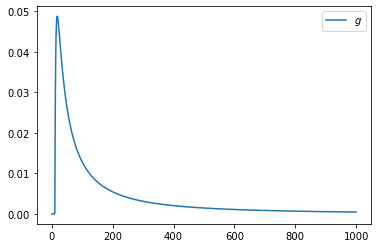

In [3]:
from scipy.integrate import quad
from scipy.stats import lognorm

def g(x):
    return β**n * np.maximum(x - K, 0) * lognorm.pdf(x, σ, loc=μ)

x_grid = np.linspace(0, 1000, 1000)
y_grid = [g(x) for x in x_grid]

fig, ax = plt.subplots()
ax.plot(x_grid, y_grid, label="$g$")
ax.legend()
plt.show()

The integral and hence the price is

In [4]:
integral, error = quad(g, 0, 100_000)
integral

4.955035450241542

### Exercise 2

A common model for $\{S_t\}$ is

$$ \ln \frac{S_{t+1}}{S_t} = \mu + \sigma \xi_{t+1} $$

where $\{ \xi_t \}$ is IID and standard normal.  However, its predictions are in some ways counterfactual.  For example, volatility is not stationary but rather changes over time.  Here's an improved version:

$$ \ln \frac{S_{t+1}}{S_t} = \mu + \sigma_t \xi_{t+1} $$

where 

$$ 
    \sigma_t = \exp(h_t), 
    \quad
        h_{t+1} = \rho h_t + \nu \eta_{t+1}
$$

Here $\{\eta_t\}$ is also IID and standard normal.

Write a function that simulates the sequence $S_0, \ldots, S_n$, where the parameters are set to 

In [5]:
μ  = 0.0001
ρ  = 0.1
ν  = 0.001
S0 = 10
h0 = 0
n  = 20


(Here `S0` is $S_0$ and `h0` is $h_0$.)

Plot 50 paths of the form $S_0, \ldots, S_n$.  

### Solution 

With $s_t := \ln S_t$, the price dynamics become

$$ s_{t+1} = s_t + \mu + \exp(h_t) \xi_{t+1} $$

Here is a function to simulate a path using this equation:

In [6]:
from numpy.random import randn

def simulate_asset_price_path(μ=μ, S0=S0, h0=h0, n=n, ρ=ρ, ν=ν):
    s = np.empty(n+1)
    s[0] = np.log(S0)

    h = h0
    for t in range(n):
        s[t+1] = s[t] + μ + np.exp(h) * randn()
        h = ρ * h + ν * randn()
        
    return np.exp(s)

Here we plot the paths and the log of the paths.

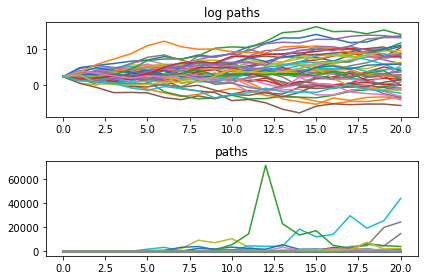

In [7]:
fig, axes = plt.subplots(2, 1)

titles = 'log paths', 'paths'
transforms = np.log, lambda x: x
for ax, transform, title in zip(axes, transforms, titles):
    for i in range(50):
        path = simulate_asset_price_path()
        ax.plot(transform(path))
    ax.set_title(title)
    
fig.tight_layout()
plt.show()

### Exercise 3

Compute the price of the option $P_0$ by Monte Carlo, averaging over realizations $S_n^1, \ldots, S_n^M$ of $S_n$ and appealing to the law of large numbers:

$$ \mathbb E \max\{ S_n - K, 0 \} 
    \approx
    \frac{1}{M} \sum_{m=1}^M \max \{S_n^m - K, 0 \}
    $$
    
Use the values given below:

In [25]:
M = 10_000_000
K = 100
n = 10
β = 0.95

To the extend that you can, write fast, efficient code to compute the option price.  

In particular, try to speed up the code above using `jit` or `njit` from Numba.  

### Solution

In [26]:
from numba import njit, prange

In [27]:
@njit
def compute_call_price(β=β,
                       μ=μ,
                       S0=S0,
                       h0=h0,
                       K=K,
                       n=n,
                       ρ=ρ,
                       ν=ν,
                       M=M):
    current_sum = 0.0
    # For each sample path
    for m in range(M):
        s = np.log(S0)
        h = h0
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)
        
    return β**n * current_sum / M

In [28]:
%%time 
compute_call_price()

CPU times: user 4.79 s, sys: 31.9 ms, total: 4.82 s
Wall time: 4.79 s


911.6915347953577

### Exercise 4

If you can, use `prange` from Numba to parallelize this code and make it even faster.

### Solution

In [23]:
@njit(parallel=True)
def compute_call_price_parallel(β=β,
                                μ=μ,
                                S0=S0,
                                h0=h0,
                                K=K,
                                n=n,
                                ρ=ρ,
                                ν=ν,
                                M=M):
    current_sum = 0.0
    # For each sample path
    for m in prange(M):
        s = np.log(S0)
        h = h0
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)
        
    return β**n * current_sum / M

In [24]:
%%time
compute_call_price_parallel()

CPU times: user 998 ms, sys: 7.95 ms, total: 1.01 s
Wall time: 420 ms


812.3789153974424

In [14]:
%%time
compute_call_price_parallel()

CPU times: user 7.13 s, sys: 0 ns, total: 7.13 s
Wall time: 929 ms


851.3072565665748

### Exercise 5

Try to shift the whole operation to the GPU using JAX and test your speed gain.

### Solution

In [15]:
!nvidia-smi

Tue Aug 16 09:24:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 30%   25C    P8    25W / 320W |   9092MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
import jax
import jax.numpy as jnp

In [17]:
@jax.jit
def compute_call_price_jax(β=β,
                           μ=μ,
                           S0=S0,
                           h0=h0,
                           K=K,
                           n=n,
                           ρ=ρ,
                           ν=ν,
                           M=M):

    s = jnp.full(M, np.log(S0))
    h = jnp.full(M, h0)
    for t in range(n):
        key = jax.random.PRNGKey(t)
        Z = jax.random.normal(key, (2, M))
        s = s + μ + jnp.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
    expectation = jnp.mean(jnp.maximum(jnp.exp(s) - K, 0))
        
    return β**n * expectation

In [18]:
%%time 
compute_call_price_jax()

2022-08-16 09:25:07.567607: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.91GiB (rounded to 3120014080)requested by op 
2022-08-16 09:25:07.567859: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:491] *___________________________________________________________________________________________________
2022-08-16 09:25:07.568377: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2130] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3120013840 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         0B
              constant allocation:       160B
        maybe_live_out allocation:         4B
     preallocated temp allocation:    2.91GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    2.91GiB
          

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3120013840 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         0B
              constant allocation:       160B
        maybe_live_out allocation:         4B
     preallocated temp allocation:    2.91GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    2.91GiB
              total fragmentation:     1.3KiB (0.00%)
Peak buffers:
	Buffer 1:
		Size: 76.29MiB
		Operator: op_name="broadcast.52"
		XLA Label: broadcast
		Shape: f32[2,10000000]
		==========================

	Buffer 2:
		Size: 76.29MiB
		Operator: op_name="broadcast.54"
		XLA Label: broadcast
		Shape: f32[2,10000000]
		==========================

	Buffer 3:
		Size: 76.29MiB
		Operator: op_name="broadcast.45"
		XLA Label: broadcast
		Shape: f32[2,10000000]
		==========================

	Buffer 4:
		Size: 76.29MiB
		Operator: op_name="broadcast.47"
		XLA Label: broadcast
		Shape: f32[2,10000000]
		==========================

	Buffer 5:
		Size: 76.29MiB
		Operator: op_name="broadcast.38"
		XLA Label: broadcast
		Shape: f32[2,10000000]
		==========================

	Buffer 6:
		Size: 76.29MiB
		Operator: op_name="broadcast.40"
		XLA Label: broadcast
		Shape: f32[2,10000000]
		==========================

	Buffer 7:
		Size: 76.29MiB
		Operator: op_name="broadcast.31"
		XLA Label: broadcast
		Shape: f32[2,10000000]
		==========================

	Buffer 8:
		Size: 76.29MiB
		Operator: op_name="broadcast.33"
		XLA Label: broadcast
		Shape: f32[2,10000000]
		==========================

	Buffer 9:
		Size: 76.29MiB
		Operator: op_name="broadcast.24"
		XLA Label: broadcast
		Shape: f32[2,10000000]
		==========================

	Buffer 10:
		Size: 76.29MiB
		Operator: op_name="broadcast.26"
		XLA Label: broadcast
		Shape: f32[2,10000000]
		==========================

	Buffer 11:
		Size: 76.29MiB
		Operator: op_name="broadcast.18"
		XLA Label: broadcast
		Shape: f32[2,10000000]
		==========================

	Buffer 12:
		Size: 76.29MiB
		Operator: op_name="broadcast.20"
		XLA Label: broadcast
		Shape: f32[2,10000000]
		==========================

	Buffer 13:
		Size: 76.29MiB
		XLA Label: broadcast
		Shape: f32[2,10000000]
		==========================

	Buffer 14:
		Size: 76.29MiB
		XLA Label: broadcast
		Shape: f32[2,10000000]
		==========================

	Buffer 15:
		Size: 76.29MiB
		Operator: op_name="jit(compute_call_price_jax)/jit(main)/mul" source_file="/tmp/ipykernel_3583610/2847803634.py" source_line=16
		XLA Label: broadcast
		Shape: f32[2,10000000]
		==========================



In [91]:
%%time 
compute_call_price_jax()

CPU times: user 35.9 ms, sys: 7.99 ms, total: 43.9 ms
Wall time: 41.1 ms


DeviceArray(873.7056, dtype=float32)